# SIR

https://www.kaggle.com/code/saga21/covid-global-forecast-sir-model-ml-regressions/notebook

In [1]:
# TODO: AÑADIR EXPLICACIONES DE GRAFICAS MOTIVACIOM ETC
# TODO: 

## Setup

In [1]:
# data handling
import pandas as pd
import numpy as np

# visualizations
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.io as pio
pio.templates.default = "plotly_white"


# for compartmental models
import comod
from comod.models import sir  # Standard SIR model
from numpy.lib.stride_tricks import sliding_window_view

# path handling
from pathlib import Path

# filter warnings
import warnings
warnings.filterwarnings("ignore")

## Data

In [2]:
# name of the file
file_name = 'spanish-covid-19-data-renave-01Jun2022.csv'

# data path
base_dir = Path(os.getcwd()).parents[0]

# path to read final data
path_to_read_final_data = base_dir / 'data' / 'final-data' / file_name	

In [3]:
df = pd.read_csv(path_to_read_final_data, parse_dates=['Date'])
df.set_index(['Date'], inplace=True)
df.head()

,Population,Infected,Deaths,Recovered
Date,,,,
2020-01-07,46796540,0.0,0.0,0.0
2020-01-08,46796540,0.0,0.0,0.0
2020-01-09,46796540,0.0,0.0,0.0
2020-01-10,46796540,0.0,0.0,0.0
2020-01-11,46796540,0.0,0.0,0.0


## Metrics

In [4]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
from sklearn.metrics import mean_squared_log_error

def RMSLE(y_true:np.ndarray, y_pred:np.ndarray) -> np.float64:
    """
        The Root Mean Squared Log Error (RMSLE) metric 
        
        :param y_true: The ground truth labels given in the dataset
        :param y_pred: Our predictions
        :return: The RMSLE score
    """
    return np.sqrt(mean_squared_log_error(y_true, y_pred))


## Prepare data 

In [5]:
# constant population
POPULATION = df['Population'].mean()

df2 = df[['Infected', 'Deaths', 'Recovered']]

In [6]:
# Confirmed, Deaths, Recovered and Active cases to SIR form
def CDRA_to_SIR(df, population):
    df2 = df[[]].copy()
    df2["S"] = 0  # Just to produce the desired order
    df2["I"] = df[["Infected"]]
    df2["R"] = df["Deaths"] + df["Recovered"]
    df2["S"] = population - df2["I"] - df2["R"]
    return df2

<AxesSubplot:xlabel='Date', ylabel='I'>

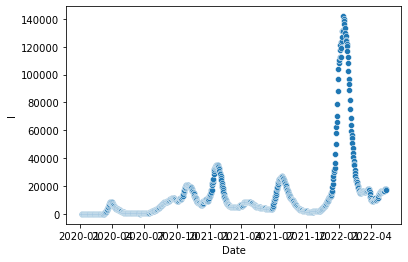

In [7]:
df3 = CDRA_to_SIR(df2, POPULATION)

# select 80 days
# df3 = df3[30:(30+80)]

sns.scatterplot(df3.index, df3['I'])

In [8]:
# use day count instead of datetime
t = np.linspace(0, len(df3)-1, len(df3))

# S, I, R to array
S = df3['S'].values
I = df3['I'].values
R = df3['R'].values

# Simple SIR

In [11]:
# # define a SIR model
# model = comod.Model(
#     ["S", "I", "R"],  # States
#     ["beta", "gamma"],  # Coefficients
#     [  # Rules in the form (origin, destination, coefficient)
#         ("S", "I", "beta I / N"),  # N is a special state with the total population
#         ("I", "R", "gamma"),
#     ],
#     # Special state names can be set with the following options:
#     # Total population. Can be used in the coefficients, but not as origin/destination.
#     sum_state="N", 
#     # The nothingness (?) from which one is born and to which one dies.
#     nihil_state="!",  # Can be used as origin/destination, but not in the cofficients.
# )


In [12]:
# # best-fit model
# fit_pars = model.best_fit(
#     np.asarray([S, I, R]), t, [0.2, 0.2]  # Existing data  # Time mesh  # Initial guess
# ).x

# print("Fitted parameters:")
# for par, value in zip(model.parameters, fit_pars):
#     print("%s: %.3f" % (par, value))

In [13]:
# fit_beta, fit_gamma = fit_pars

In [14]:
# S, I, R = model.solve(
#     (S[0], I[0], R[0]),  # Initial state
#     [fit_beta, fit_gamma],  # Coefficient values
#     t,  # Time mesh
#     method="RK45",  # see scipy.integrate.solve_ivp
# )

In [15]:
# plt.plot(t, I)
# sns.scatterplot(t, df3['I'])

# SIR with Sliding windows

In [10]:
# define a SIR model
model = comod.Model(
    ["S", "I", "R"],  # States
    ["beta", "gamma"],  # Coefficients
    [  # Rules in the form (origin, destination, coefficient)
        ("S", "I", "beta I / N"),  # N is a special state with the total population
        ("I", "R", "gamma"),
    ],
    # Special state names can be set with the following options:
    # Total population. Can be used in the coefficients, but not as origin/destination.
    sum_state="N", 
    # The nothingness (?) from which one is born and to which one dies.
    nihil_state="!",  # Can be used as origin/destination, but not in the cofficients.
)


In [11]:
%%time

window_size=10
step_size=10

results = model.best_sliding_fit(
    np.asarray([S, I, R]),  # Existing data
    t,  # Time mesh
    [0.1, 0.1],  # Initial conditions
    window_size=window_size,  # Window size (number of time values in each window)
    step_size=step_size,  # Number of time steps between windows
    target=
    "y",  # The target to minimize can be "y" (values) or "dy" (their derivatives)
    time_criterion="first",  # Determines how a time is assigned to each window in the solution
)
results

CPU times: total: 4.08 s
Wall time: 4.28 s


,beta,gamma
0.0,0.100000,0.100000
10.0,0.100000,0.100000
20.0,0.100000,0.100000
30.0,0.100000,0.100000
40.0,0.100000,0.100000
...,...,...
800.0,0.023320,0.011695
810.0,-0.176746,-0.085735
820.0,0.040585,0.020624
830.0,0.094099,0.046989


Window 0
	baseline: 0.0
	SIR: 0.0


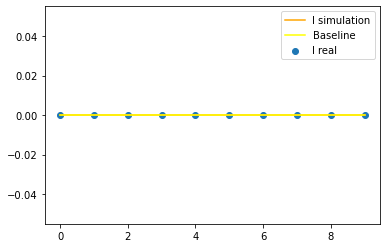

Window 1
	baseline: 0.0
	SIR: 0.0


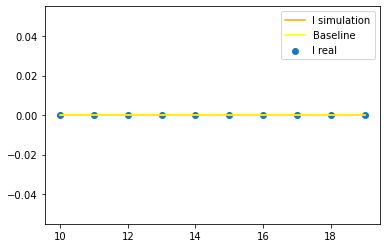

Window 2
	baseline: 0.0
	SIR: 0.0


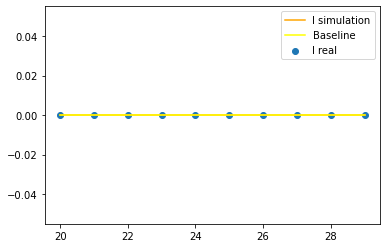

Window 3
	baseline: 0.0
	SIR: 0.0


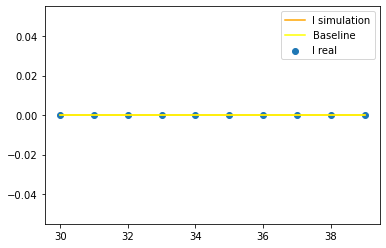

Window 4
	baseline: 0.6575771532880239
	SIR: 0.21919238442934127


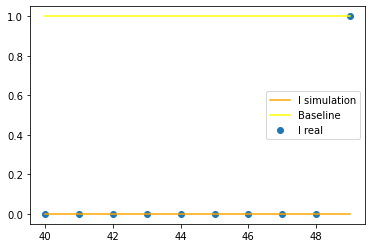

Window 5
	baseline: 2.0036060784616714
	SIR: 0.26191546996662807


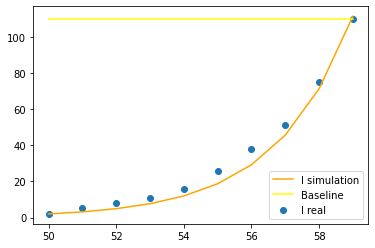

Window 6
	baseline: 1.4549490361378534
	SIR: 0.14579264801198757


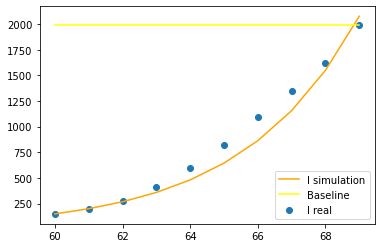

Window 7
	baseline: 0.6318891762960265
	SIR: 0.06698908839255266


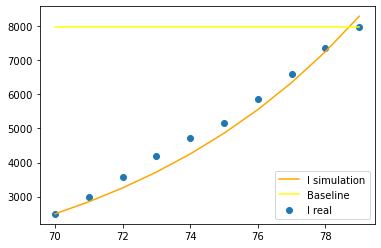

Window 8
	baseline: 0.21423610069279053
	SIR: 0.05288930817081013


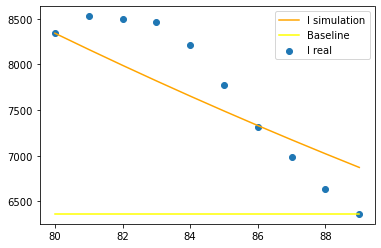

Window 9
	baseline: 0.29907964981252066
	SIR: 0.009944900400052045


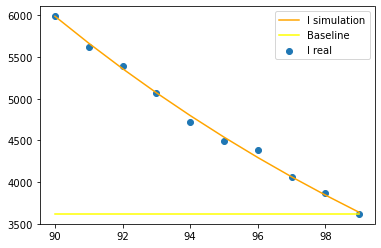

Window 10
	baseline: 0.29108326656143735
	SIR: 0.02178021690070019


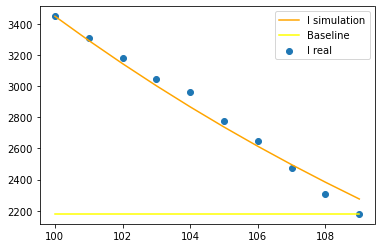

Window 11
	baseline: 0.47184918543704807
	SIR: 0.024175384924617786


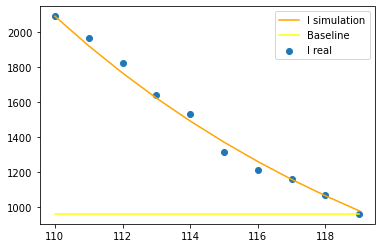

Window 12
	baseline: 0.1101099089495851
	SIR: 0.02475439336224065


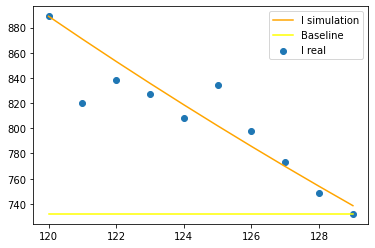

Window 13
	baseline: 0.06171472243054771
	SIR: 0.041486682753805


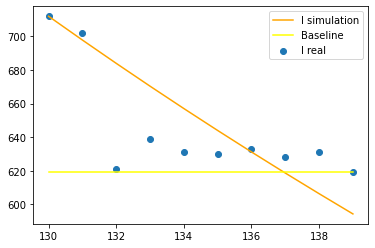

Window 14
	baseline: 0.1718188740572424
	SIR: 0.021487560006622504


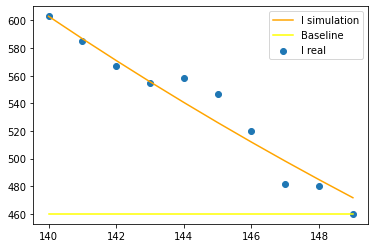

Window 15
	baseline: 0.20030689492758402
	SIR: 0.03528558980758457


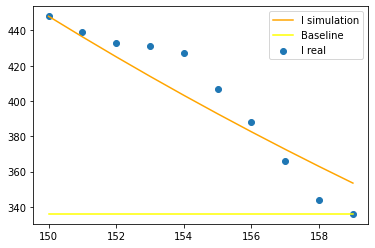

Window 16
	baseline: 0.03458305303300907
	SIR: 0.04021200172885004


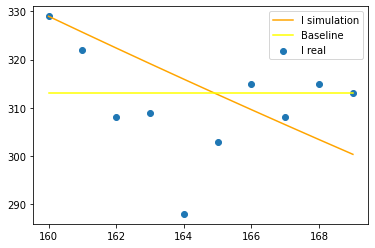

Window 17
	baseline: 0.14881496470764918
	SIR: 0.018421669972897153


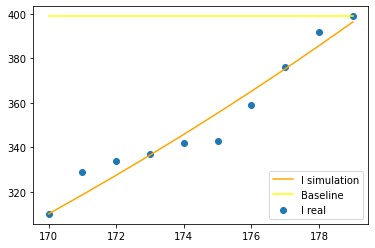

Window 18
	baseline: 0.47842078063453214
	SIR: 0.03539079781050598


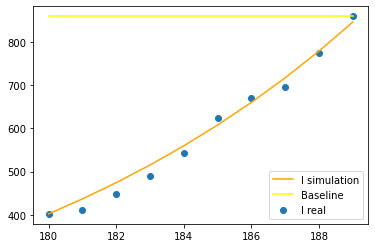

Window 19
	baseline: 0.3953812697463607
	SIR: 0.04425361570223899


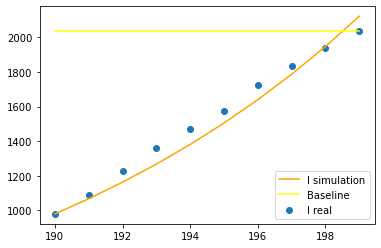

Window 20
	baseline: 0.24700276670143526
	SIR: 0.026554657809354117


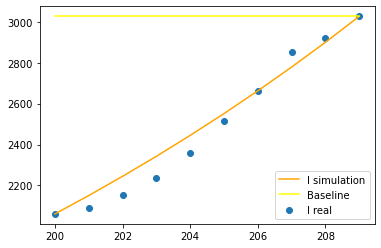

Window 21
	baseline: 0.26970850985741784
	SIR: 0.016520716607592228


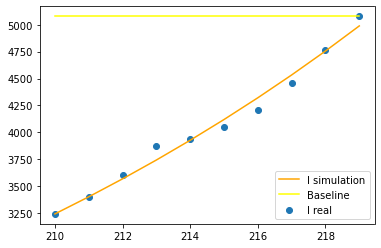

Window 22
	baseline: 0.18831372823143444
	SIR: 0.014350183872909943


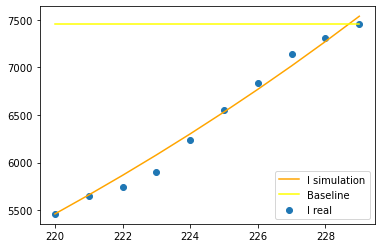

Window 23
	baseline: 0.0767221281916153
	SIR: 0.01884276568439896


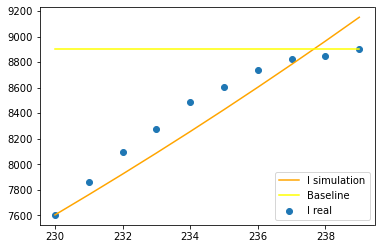

Window 24
	baseline: 0.09280121402868664
	SIR: 0.010262277664008123


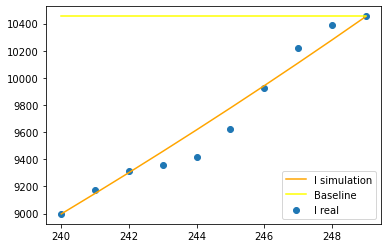

Window 25
	baseline: 0.033660401732935157
	SIR: 0.02009667971545249


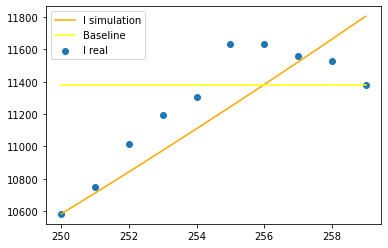

Window 26
	baseline: 0.10195541861192525
	SIR: 0.0069652245566044465


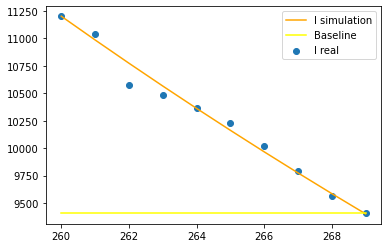

Window 27
	baseline: 0.08713929721620287
	SIR: 0.017634633301344307


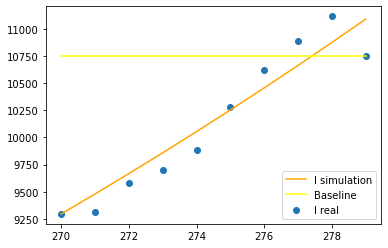

Window 28
	baseline: 0.30408033974119325
	SIR: 0.026822751797270176


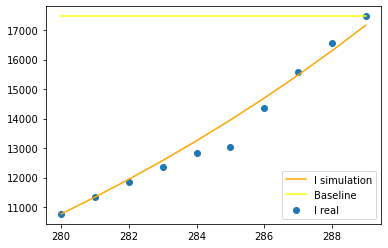

Window 29
	baseline: 0.05369515776887818
	SIR: 0.0225359590100854


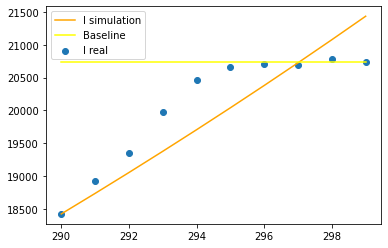

Window 30
	baseline: 0.05544337895223478
	SIR: 0.007316610044045738


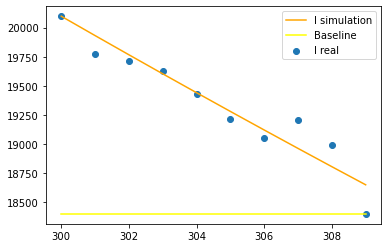

Window 31
	baseline: 0.2527666235805573
	SIR: 0.019975664603452927


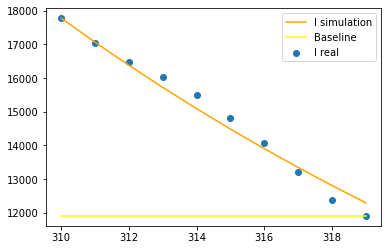

Window 32
	baseline: 0.20352809441594505
	SIR: 0.030316393977328226


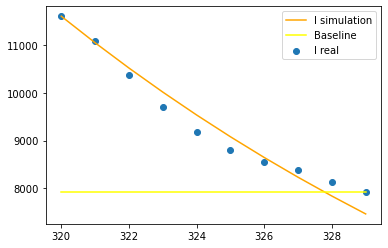

Window 33
	baseline: 0.08088721870759707
	SIR: 0.048467621777609195


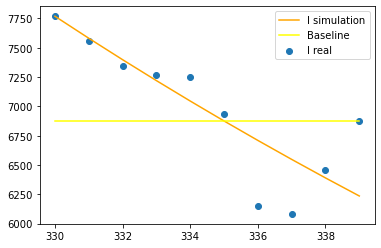

Window 34
	baseline: 0.16604766338284824
	SIR: 0.06402980433794463


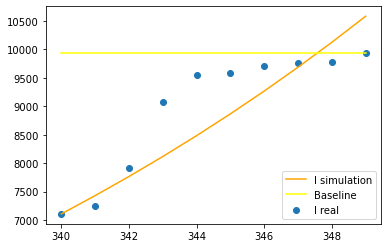

Window 35
	baseline: 0.21516639682716815
	SIR: 0.08438240363552811


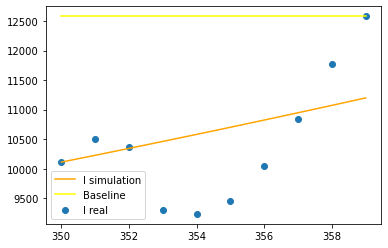

Window 36
	baseline: 0.36261052766312896
	SIR: 0.05077083655559856


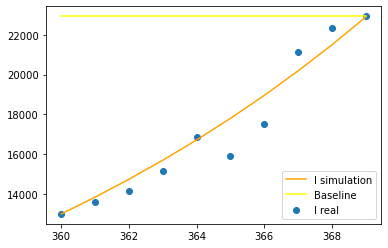

Window 37
	baseline: 0.17607332632185502
	SIR: 0.05325614204987212


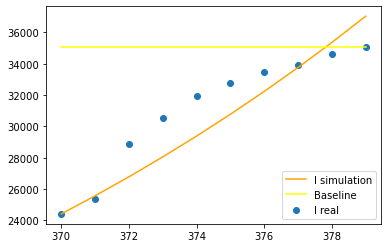

Window 38
	baseline: 0.1317449629090255
	SIR: 0.02599519742612792


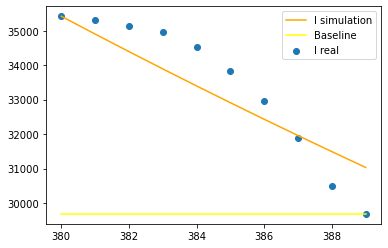

Window 39
	baseline: 0.3645435209003577
	SIR: 0.012271366378682747


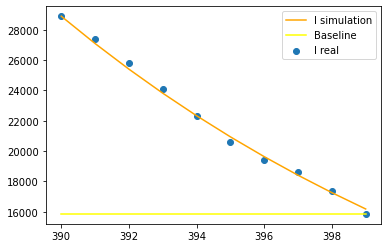

Window 40
	baseline: 0.36431816805148537
	SIR: 0.022870682876402263


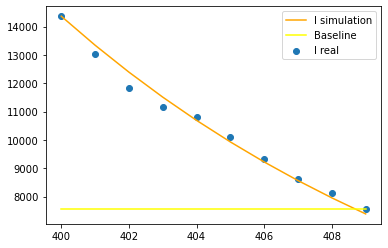

Window 41
	baseline: 0.1825924924692543
	SIR: 0.01594568996361478


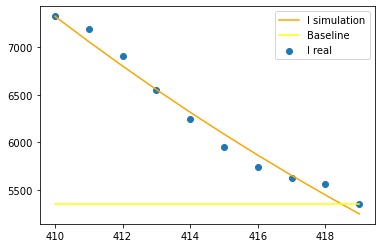

Window 42
	baseline: 0.054777407953666105
	SIR: 0.00758261461368471


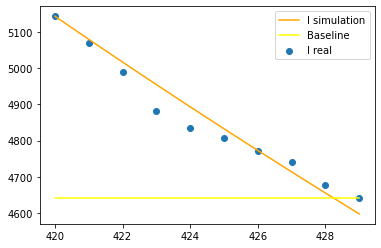

Window 43
	baseline: 0.029238392554189137
	SIR: 0.012203442969138532


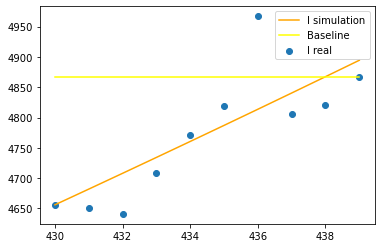

Window 44
	baseline: 0.176752033613525
	SIR: 0.014023660937751535


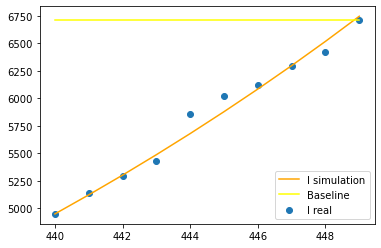

Window 45
	baseline: 0.26716802915030563
	SIR: 0.09296306190875342


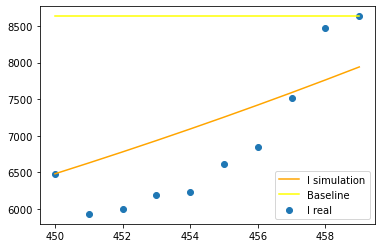

Window 46
	baseline: 0.01730945307660582
	SIR: 0.010119402364942943


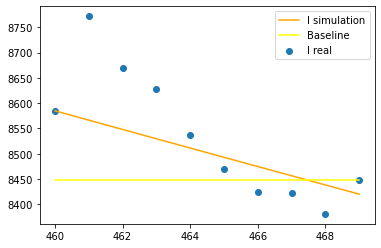

Window 47
	baseline: 0.05062579552811825
	SIR: 0.010651818274577564


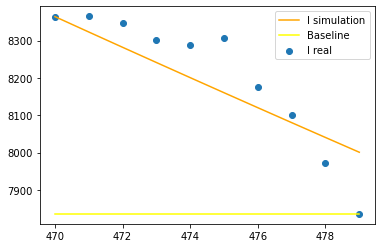

Window 48
	baseline: 0.13484343114473138
	SIR: 0.020675728291422314


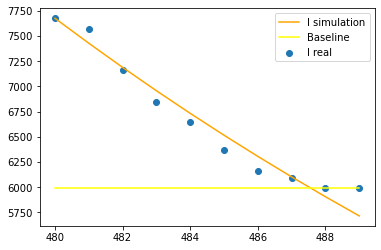

Window 49
	baseline: 0.09246291478849905
	SIR: 0.028730393976182468


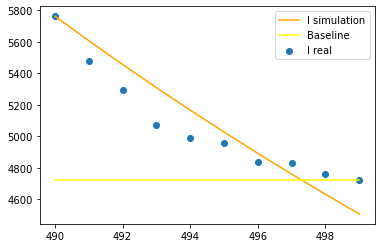

Window 50
	baseline: 0.03184265494764541
	SIR: 0.008874566971894015


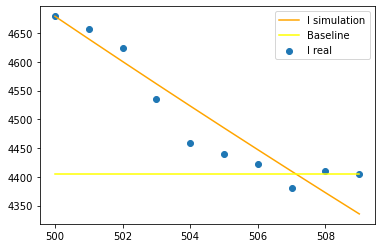

Window 51
	baseline: 0.1303319177274232
	SIR: 0.014058911838068911


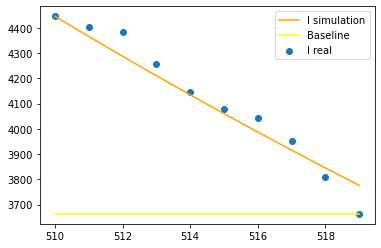

Window 52
	baseline: 0.033495149527086134
	SIR: 0.01221424069607493


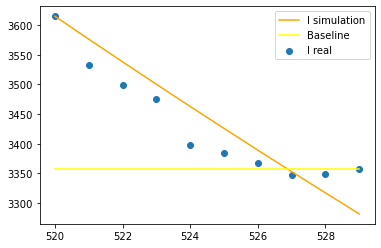

Window 53
	baseline: 0.40961012656890594
	SIR: 0.08032252468934097


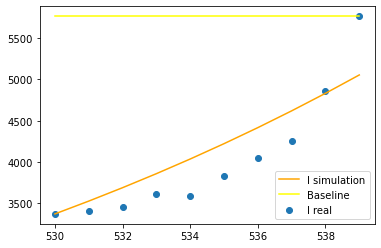

Window 54
	baseline: 0.5094284587548688
	SIR: 0.062552122181848


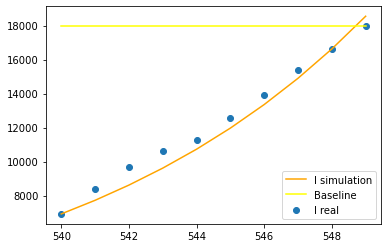

Window 55
	baseline: 0.17239934865923492
	SIR: 0.026227074795135544


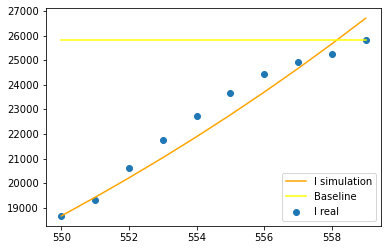

Window 56
	baseline: 0.08446439643862892
	SIR: 0.02737569179530377


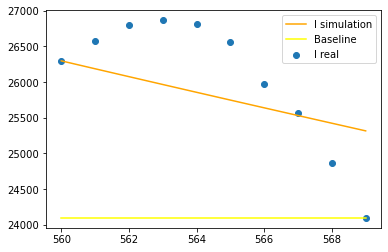

Window 57
	baseline: 0.2000706479074799
	SIR: 0.017300681165710718


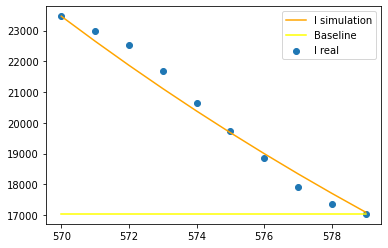

Window 58
	baseline: 0.24161383541026718
	SIR: 0.010833471431937686


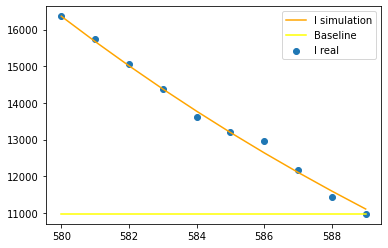

Window 59
	baseline: 0.2198831423130428
	SIR: 0.03231567281843579


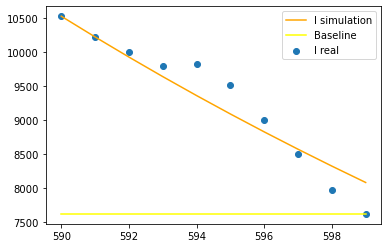

Window 60
	baseline: 0.32034410527719953
	SIR: 0.02095101476150632


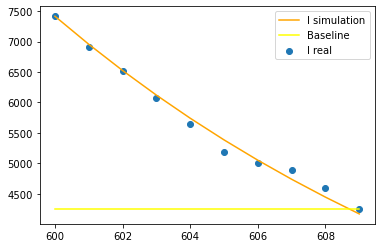

Window 61
	baseline: 0.2281176840715461
	SIR: 0.008864324901008596


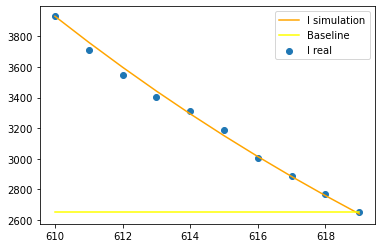

Window 62
	baseline: 0.11729459777969406
	SIR: 0.024617242501841198


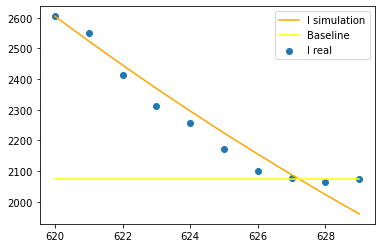

Window 63
	baseline: 0.15869464811684839
	SIR: 0.009007117941839527


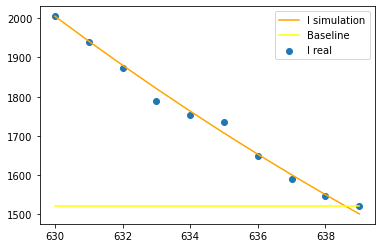

Window 64
	baseline: 0.055867340683050555
	SIR: 0.04160830614167171


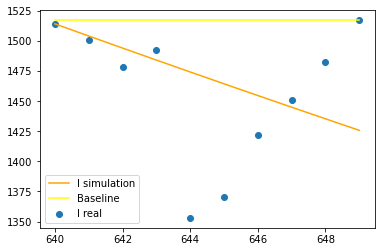

Window 65
	baseline: 0.052692837624100944
	SIR: 0.04930407590123321


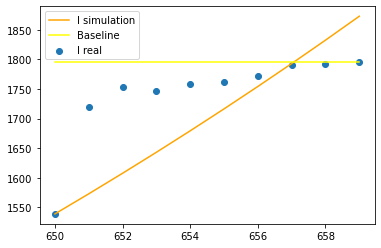

Window 66
	baseline: 0.16455883213869255
	SIR: 0.050450793428488946


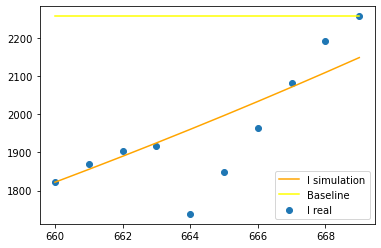

Window 67
	baseline: 0.3494589195840572
	SIR: 0.033811848048483695


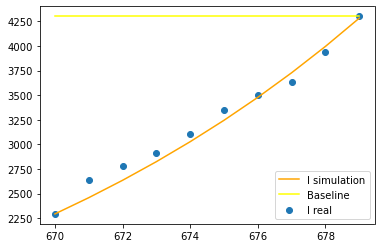

Window 68
	baseline: 0.30958280601789895
	SIR: 0.015098439932031357


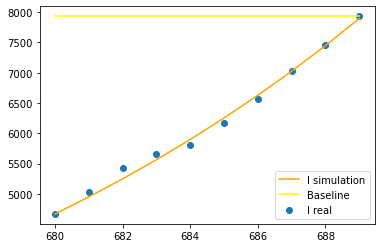

Window 69
	baseline: 0.2276823401859841
	SIR: 0.033083966744531464


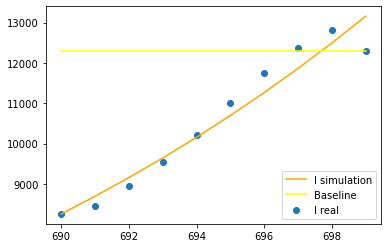

Window 70
	baseline: 0.5265538616853808
	SIR: 0.08769815965560585


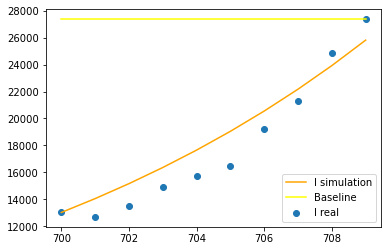

Window 71
	baseline: 0.5245840221712033
	SIR: 0.05776932397974282


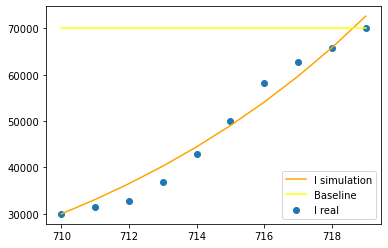

Window 72
	baseline: 0.2094299671009826
	SIR: 0.0645317261735953


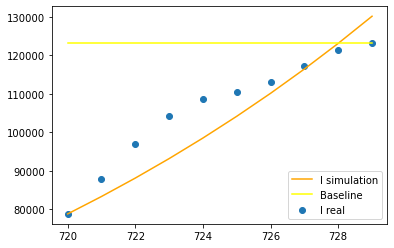

Window 73
	baseline: 0.09749678387741229
	SIR: 0.02895666451316455


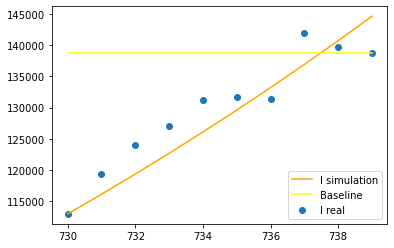

Window 74
	baseline: 0.1135508705369968
	SIR: 0.008354990597086623


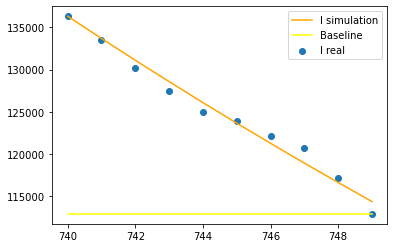

Window 75
	baseline: 0.3777669425078289
	SIR: 0.03029253991699117


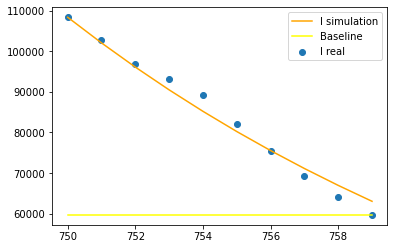

Window 76
	baseline: 0.34741749134174604
	SIR: 0.014370322878615904


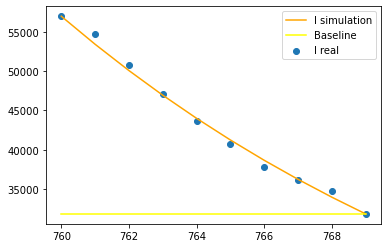

Window 77
	baseline: 0.259380352182484
	SIR: 0.025286042723682428


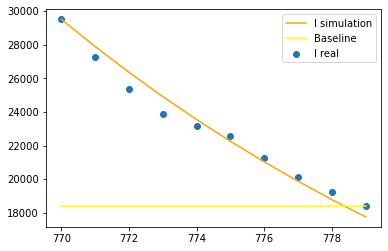

Window 78
	baseline: 0.05243771230497783
	SIR: 0.04228062931996507


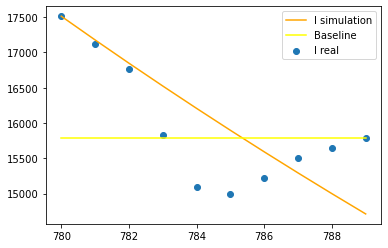

Window 79
	baseline: 0.02127505993853453
	SIR: 0.015335678923903605


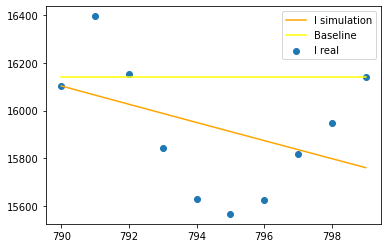

Window 80
	baseline: 0.04303619288074503
	SIR: 0.016103624712812955


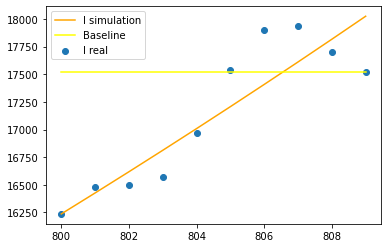

Window 81
	baseline: 0.32133205879632815
	SIR: 0.07592019554268123


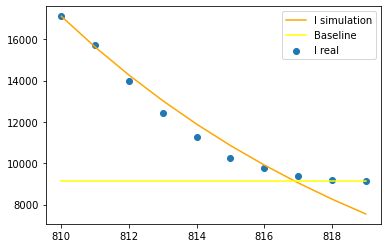

Window 82
	baseline: 0.06606275639889769
	SIR: 0.043916496898711105


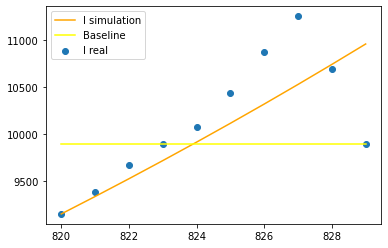

Window 83
	baseline: 0.25423603054796057
	SIR: 0.039704470823877104


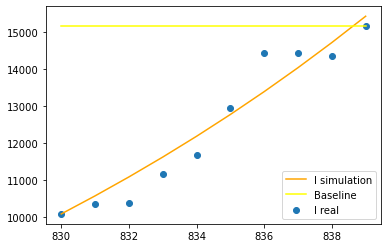

Window 84
	baseline: 0.034466598309298775
	SIR: 0.025784003966378956


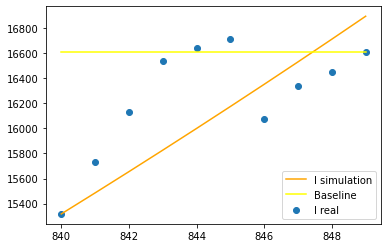

In [15]:
total_S_simulated = []
total_I_simulated = []
total_R_simulated = []
total_baseline = []

number_of_windows = len(results)

for i in range(number_of_windows):

    # ============= fit the model to the data ======================
    print("Window %d" % i)

    start_point = int(results.index[i])  # first time point of the window
    
    S0, I0, R0 = S[start_point], I[start_point], R[start_point] # initial states

    fit_beta, fit_gamma = results.iloc[i][["beta", "gamma"]]  # best params per window

    t_window = t[start_point: start_point +
                 window_size]  # time mesh for the window

    S_simulated, I_simulated, R_simulated = model.solve(
        (S0, I0, R0),  # Initial states
        [fit_beta, fit_gamma],  # Coefficient values
        t_window,  # Time mesh
        method="RK45",  # see scipy.integrate.solve_ivp
    )

    total_S_simulated.extend(S_simulated) # add simulation to total S simulated
    total_I_simulated.extend(I_simulated) # add simulation to total I simulated
    total_R_simulated.extend(R_simulated) # add simulation to total R simulated

    # ============= EVALUATION =============
    # baseline = [np.mean(I[start_point: start_point + window_size])]*window_size # define baseline as the mean of the elements of the window
    baseline = np.repeat(I[start_point: start_point + window_size][-1],window_size) # define baseline as the repetition of the last element of the window
    total_baseline.extend(baseline) # add baseline to total baseline

    baseline_RMSLE = RMSLE(I[start_point: start_point + window_size], baseline) # evaluate baseline RMSLE
    sir_RMSLE = RMSLE(I[start_point: start_point + window_size], I_simulated) # evaluate sir RMSLE

    print('\tbaseline:', baseline_RMSLE)
    print('\tSIR:', sir_RMSLE)

    # ============= PLOTTING =============
    plt.plot(t_window, I_simulated, color='orange', label='I simulation') # plot simulated I
    plt.plot(t_window, baseline, color='yellow', label='Baseline') # plot baseline
    plt.scatter(t_window, df3[start_point: start_point + window_size]['I'], label='I real') # plot real I
    plt.legend()
    plt.show()


	baseline: 0.21218675031079307
	SIR: 0.053777561841934884


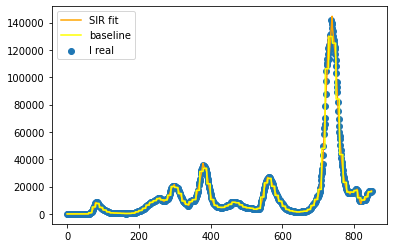

In [13]:
# baseline overall evaluation    
print('\tbaseline:', RMSLE(I[:len(total_I_simulated)], total_baseline))
# sir overall evaluation
print('\tSIR:', RMSLE(I[:len(total_I_simulated)], total_I_simulated))

plt.plot(t[:len(total_I_simulated)], total_I_simulated, color='orange', label='SIR fit')
plt.plot(t[:len(total_I_simulated)], total_baseline, color='yellow', label='baseline')
plt.scatter(t[:len(total_I_simulated)], I[:len(total_I_simulated)], label='I real')
plt.legend()
plt.show()

## SIR to Predict next steps evolution 

In [10]:
# define a SIR model
model = comod.Model(
    ["S", "I", "R"],  # States
    ["beta", "gamma"],  # Coefficients
    [  # Rules in the form (origin, destination, coefficient)
        ("S", "I", "beta I / N"),  # N is a special state with the total population
        ("I", "R", "gamma"),
    ],
    # Special state names can be set with the following options:
    # Total population. Can be used in the coefficients, but not as origin/destination.
    sum_state="N", 
    # The nothingness (?) from which one is born and to which one dies.
    nihil_state="!",  # Can be used as origin/destination, but not in the cofficients.
)


In [11]:
%%time

window_size=8
step_size=10 # predict next (step_size-window_size) days

results = model.best_sliding_fit(
    np.asarray([S, I, R]),  # Existing data
    t,  # Time mesh
    [0.1, 0.1],  # Initial conditions
    window_size=window_size,  # Window size (number of time values in each window)
    step_size=step_size,  # Number of time steps between windows
    target=
    "y",  # The target to minimize can be "y" (values) or "dy" (their derivatives)
    time_criterion="first",  # Determines how a time is assigned to each window in the solution
)
results

Wall time: 3.3 s


,beta,gamma
0.0,0.100000,0.100000
10.0,0.100000,0.100000
20.0,0.100000,0.100000
30.0,0.100000,0.100000
40.0,0.100000,0.100000
...,...,...
810.0,-0.193603,-0.095594
820.0,0.055717,0.027755
830.0,0.100216,0.049348
840.0,0.026425,0.013364


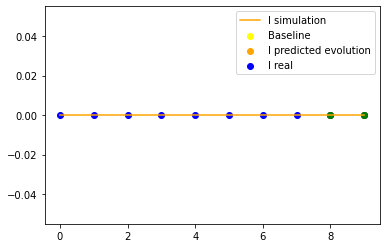

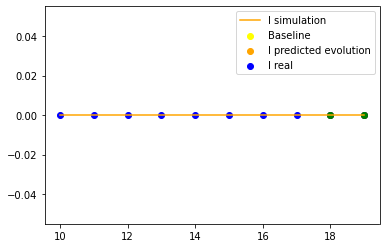

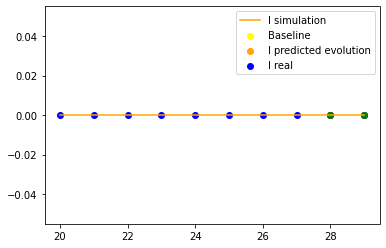

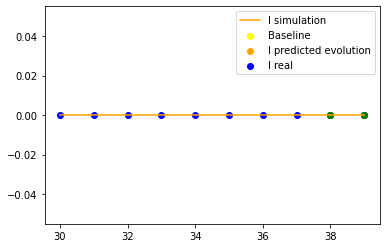

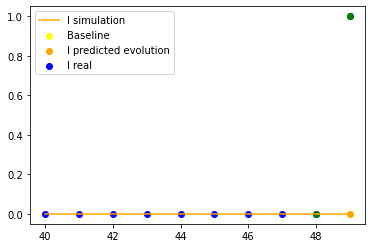

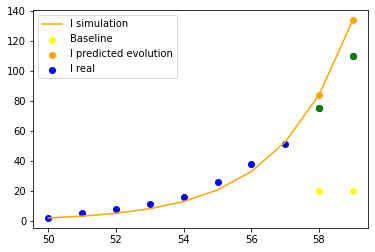

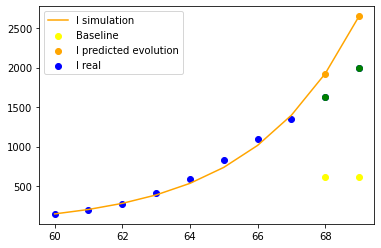

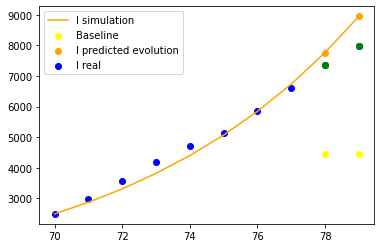

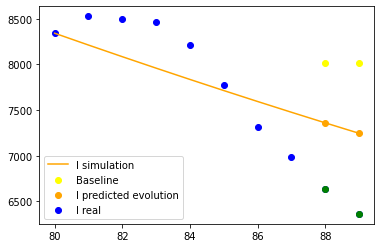

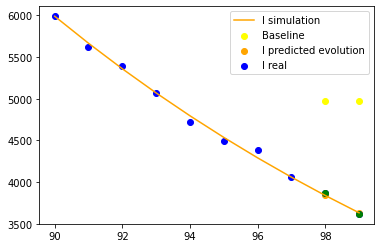

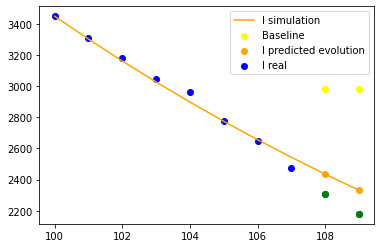

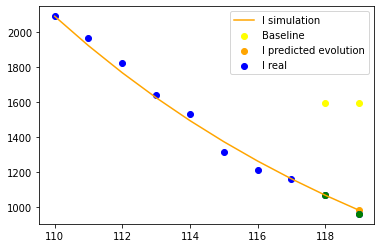

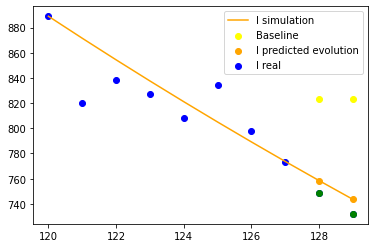

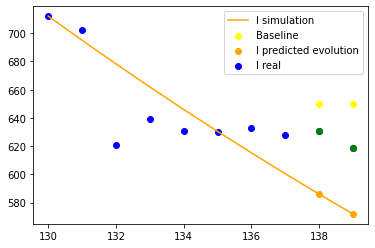

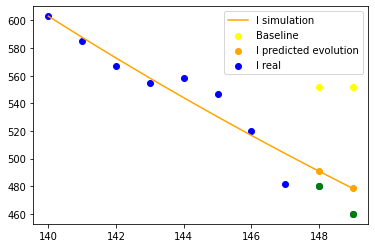

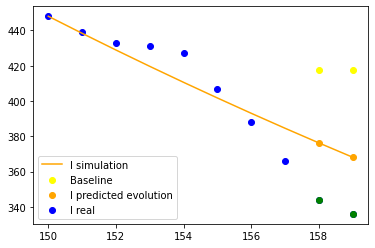

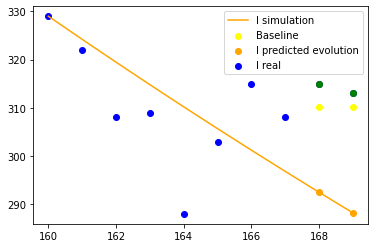

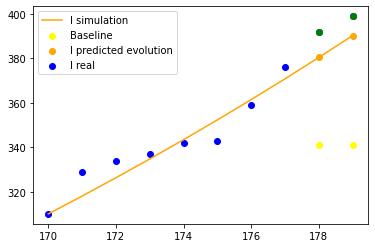

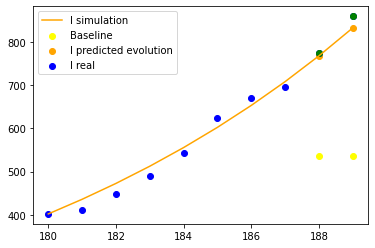

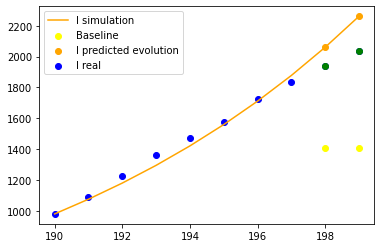

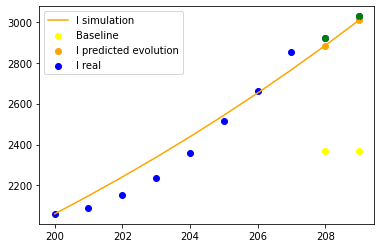

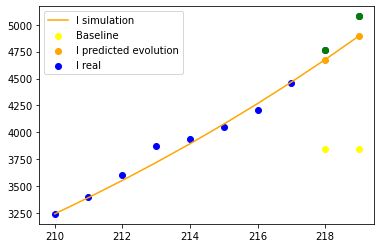

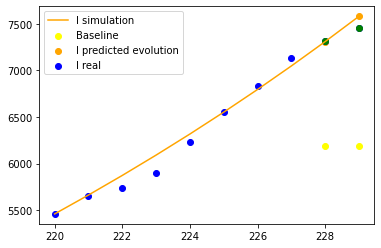

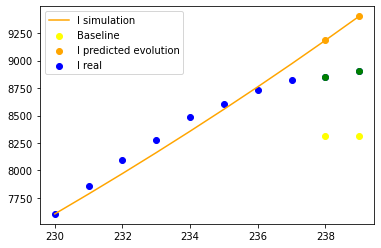

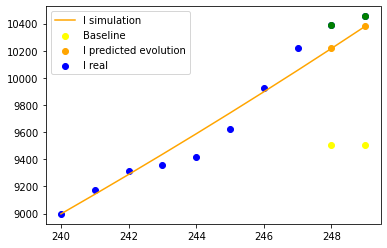

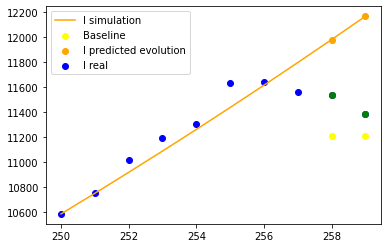

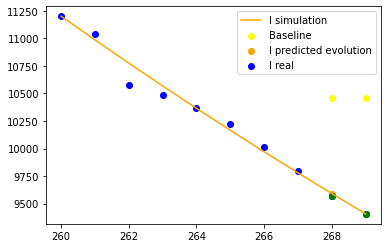

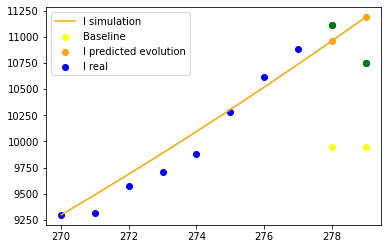

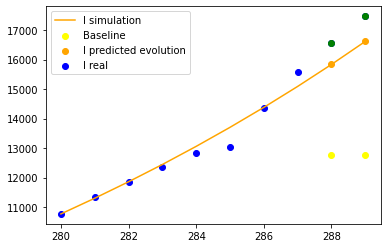

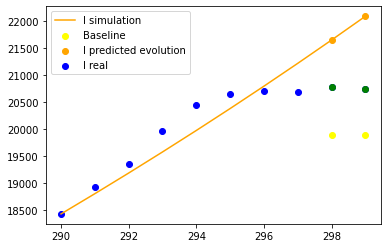

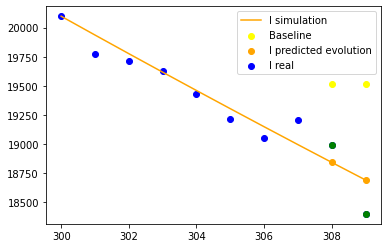

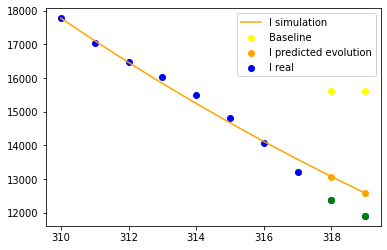

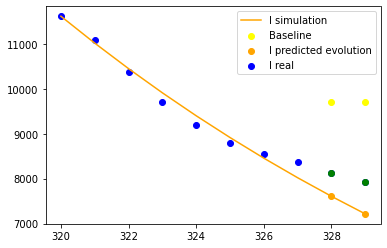

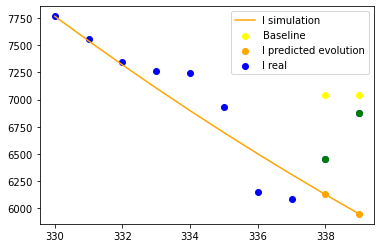

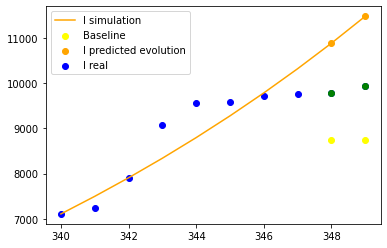

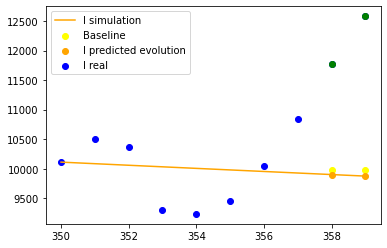

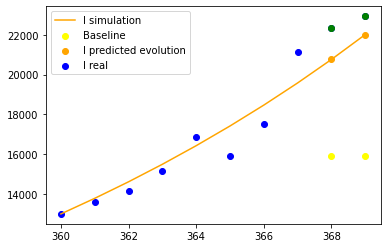

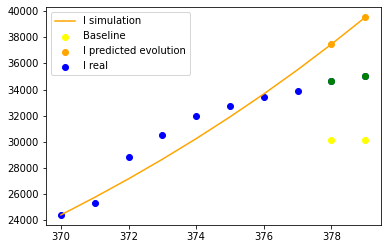

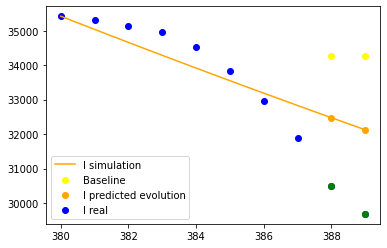

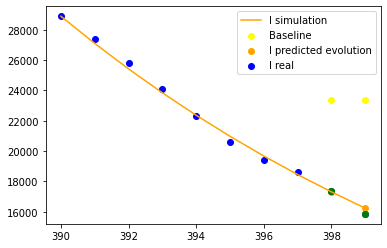

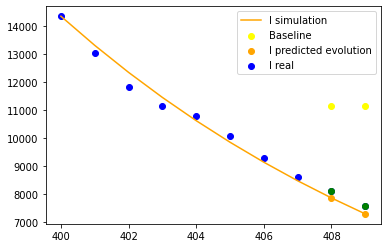

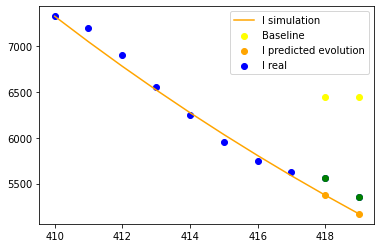

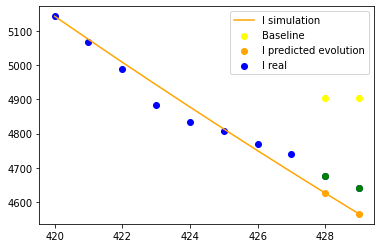

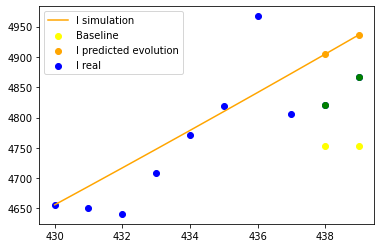

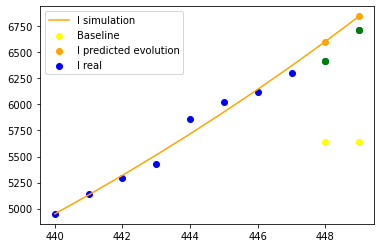

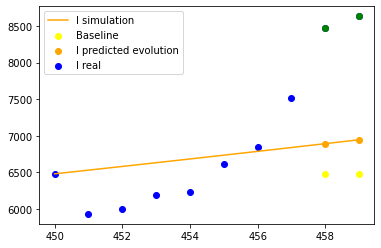

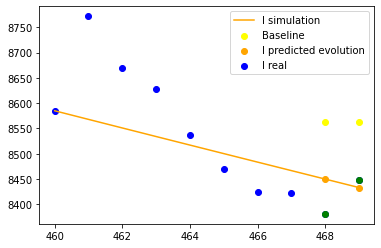

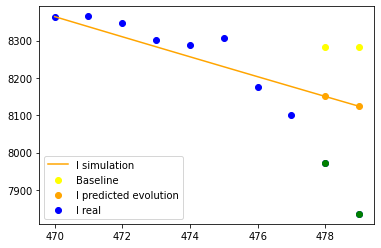

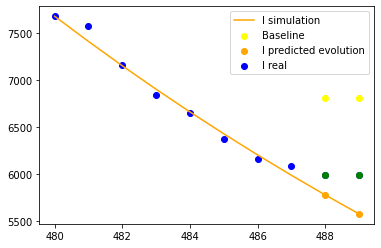

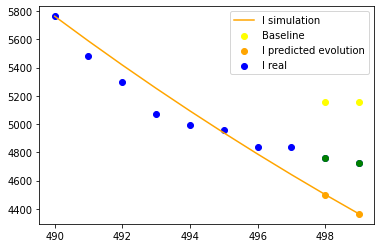

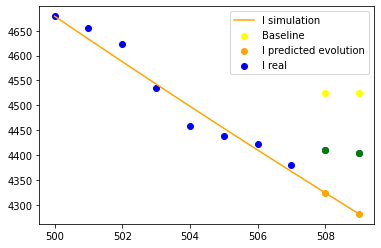

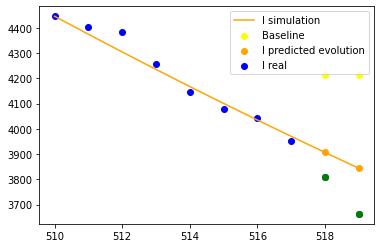

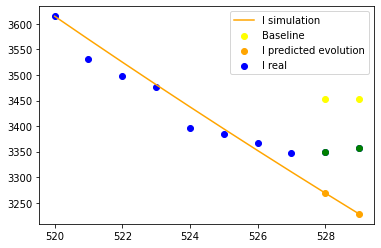

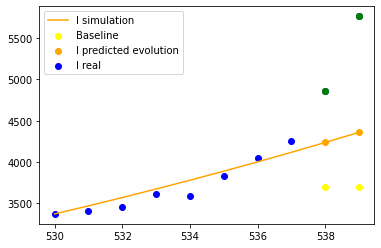

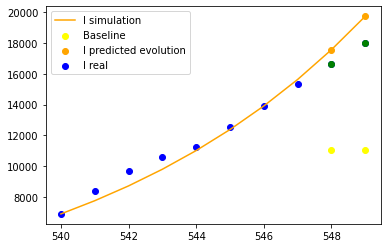

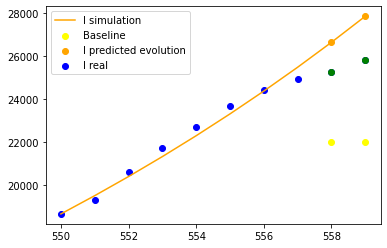

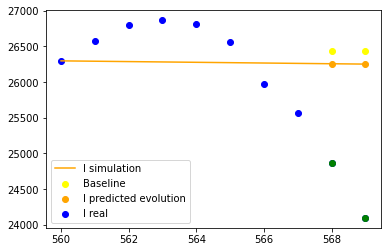

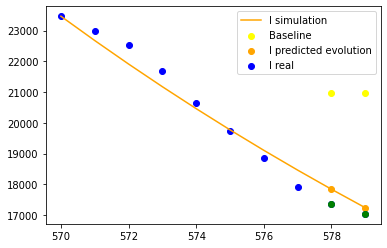

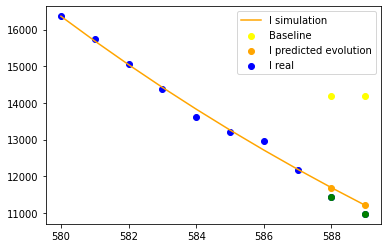

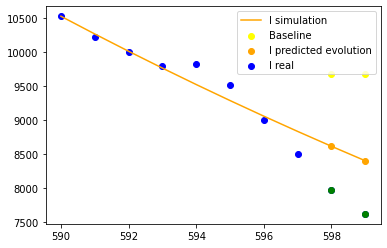

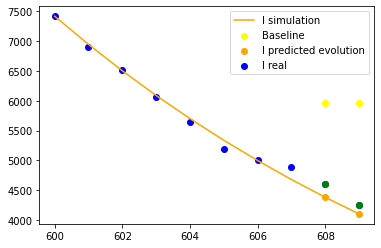

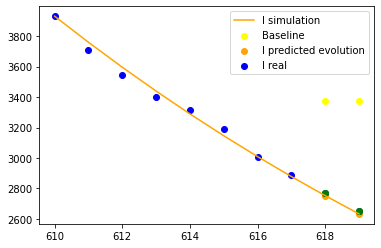

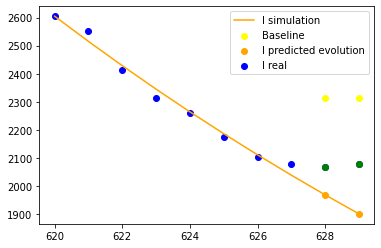

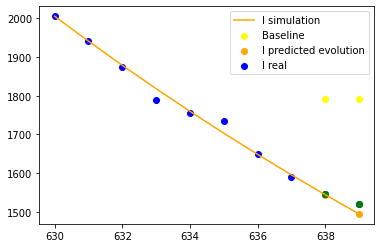

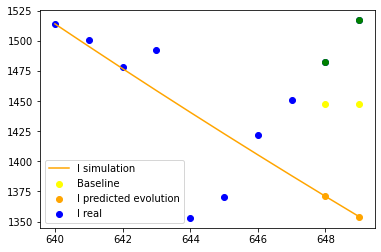

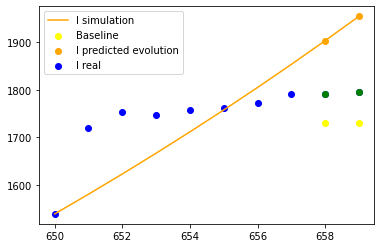

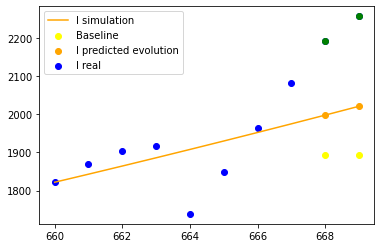

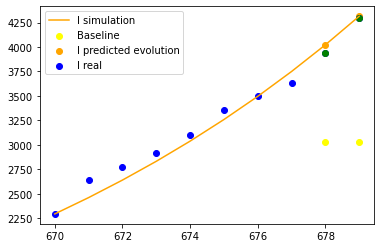

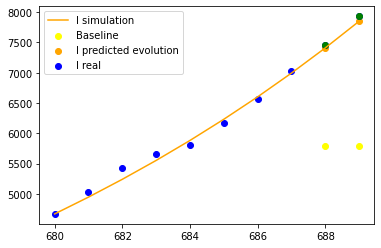

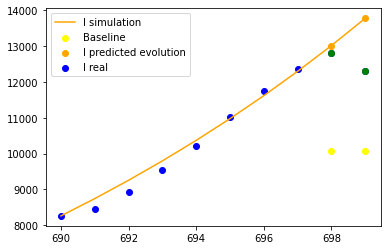

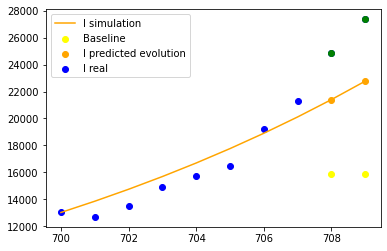

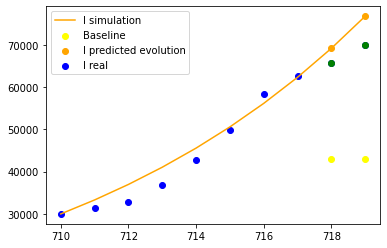

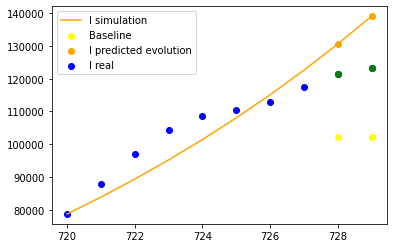

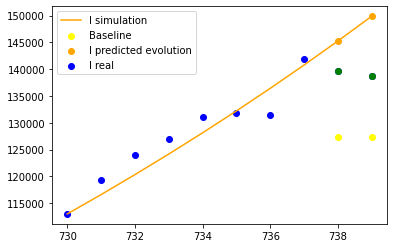

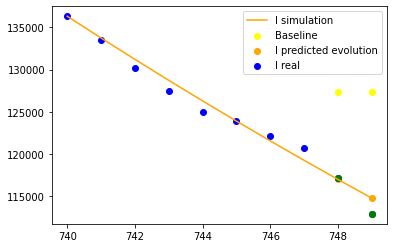

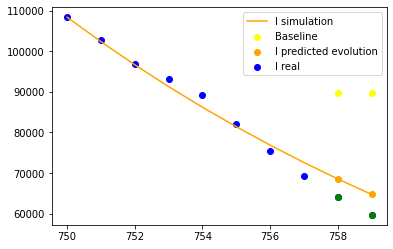

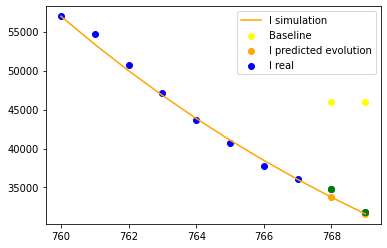

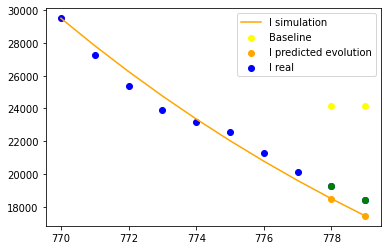

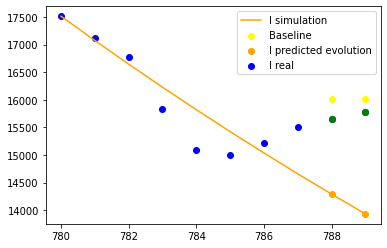

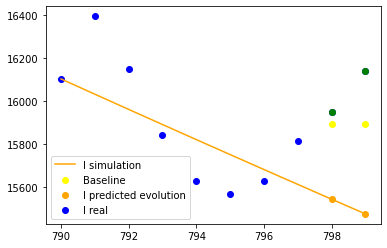

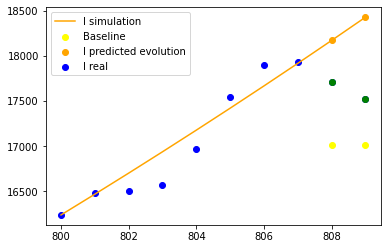

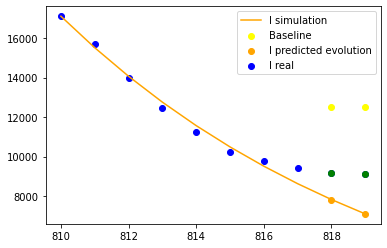

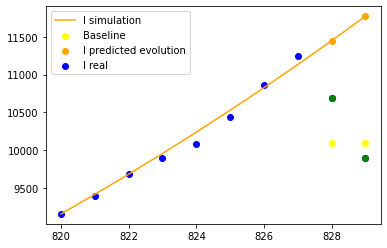

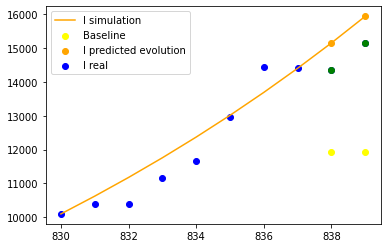

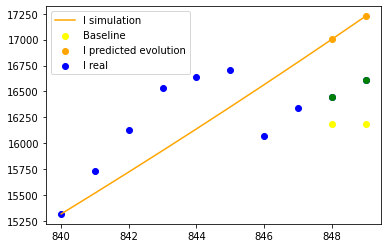

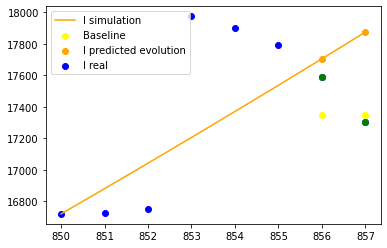

({'Window_0': {'RMSLE': 0.0,
   'mean_absolute_error': 0.0,
   'mean_squared_error': 0.0,
   'r2_score': 1.0,
   'mean_absolute_percentage_error': 0.0},
  'Window_1': {'RMSLE': 0.0,
   'mean_absolute_error': 0.0,
   'mean_squared_error': 0.0,
   'r2_score': 1.0,
   'mean_absolute_percentage_error': 0.0},
  'Window_2': {'RMSLE': 0.0,
   'mean_absolute_error': 0.0,
   'mean_squared_error': 0.0,
   'r2_score': 1.0,
   'mean_absolute_percentage_error': 0.0},
  'Window_3': {'RMSLE': 0.0,
   'mean_absolute_error': 0.0,
   'mean_squared_error': 0.0,
   'r2_score': 1.0,
   'mean_absolute_percentage_error': 0.0},
  'Window_4': {'RMSLE': 0.49012907173427356,
   'mean_absolute_error': 0.5,
   'mean_squared_error': 0.5,
   'r2_score': -1.0,
   'mean_absolute_percentage_error': 0.5},
  'Window_5': {'RMSLE': 0.1584868788477587,
   'mean_absolute_error': 16.390956815020445,
   'mean_squared_error': 324.70045437471765,
   'r2_score': -0.06024638163173113,
   'mean_absolute_percentage_error': 0.1678984

In [13]:
total_S_simulated = []
total_I_simulated = []
total_R_simulated = []
total_I_eval =[]
total_baseline = []

metrics = [mean_absolute_error, mean_squared_error, mean_absolute_percentage_error]
metrics = {metric.__name__: metric for metric in metrics}

def _evaluate_window(i, start_point, window_baseline, I_simulated):
    window_metrics = {}
    baseline_window_metrics = {}

    for metric_name, metric in metrics.items():
        baseline_window_metrics['RMSLE'] = RMSLE(I[start_point: start_point+step_size][-(step_size-window_size):], window_baseline)
        try:
            baseline_window_metrics[metric_name] = metric(I[start_point: start_point+step_size][-(step_size-window_size):], window_baseline)
        except:
            baseline_window_metrics[metric_name] = np.nan

    for metric_name, metric in metrics.items():
        window_metrics['RMSLE'] = RMSLE(I[start_point: start_point+step_size][-(step_size-window_size):], I_simulated[-(step_size-window_size):])
        try:
            window_metrics[metric_name] = metric(I[start_point: start_point+step_size][-(step_size-window_size):], I_simulated[-(step_size-window_size):])
        except:
            window_metrics[metric_name] = np.nan
    return {f'Window_{i}': window_metrics}, {f'Window_baseline_{i}': baseline_window_metrics}

def _plot_window(start_point, t_window, window_baseline, I_simulated):
    plt.plot(t_window, I_simulated, color='orange', label='I simulation') # plot simulated I
    plt.scatter(t_window[:step_size][-(step_size-window_size):], window_baseline, color='yellow', label='Baseline') # plot baseline
    plt.scatter(t_window[-(step_size-window_size):], I_simulated[-(step_size-window_size):], color='orange', label='I predicted evolution')
    plt.scatter(t_window, I[start_point:start_point+step_size], color='blue', label='I real') # plot real I
    plt.scatter(t_window[-(step_size-window_size):], I[start_point:start_point+step_size][-(step_size-window_size):], color='green') # plot real I
    plt.legend()
    plt.show()

def get_window_evaluation(plot=False):

    window_evaluation_sir_metrics = {}
    window_evaluation_baseline_metrics = {}

    number_of_windows = len(results)

    for i in range(number_of_windows):

        # ============= fit the model to the data ======================
        # print("Window %d" % i)

        start_point = int(results.index[i])

        S0, I0, R0 = S[start_point], I[start_point], R[start_point]

        fit_beta, fit_gamma = results.iloc[i][["beta", "gamma"]]

        t_window = t[start_point: start_point+step_size] # time mesh for the window with step_size>window_size

        S_simulated, I_simulated, R_simulated = model.solve(
            (S0, I0, R0),  # Initial state
            [fit_beta, fit_gamma],  # Coefficient values
            t_window,  # Time mesh
            method="RK45",  # see scipy.integrate.solve_ivp
            )
            
        total_S_simulated.extend(S_simulated[-(step_size-window_size):]) # add simulation to total S simulated
        total_I_simulated.extend(I_simulated[-(step_size-window_size):]) # add simulation to total I simulated
        total_R_simulated.extend(R_simulated[-(step_size-window_size):]) # add simulation to total R simulated

        total_I_eval.extend(I[start_point: start_point+step_size][-(step_size-window_size):]) # add last real I points to total I for evaluation

        # ============= EVALUATION =============  
        window_baseline = [np.mean(I[start_point: (start_point+step_size-(step_size-window_size))])]*(step_size-window_size) # define baseline as the mean of the elements of the window
        total_baseline.extend(window_baseline) # add baseline to total baseline
        window_metrics, window_baseline_metrics = _evaluate_window(i, start_point, window_baseline, I_simulated)  
        window_evaluation_sir_metrics.update(window_metrics)
        window_evaluation_baseline_metrics.update(window_baseline_metrics)

        # ============= PLOTTING =============
        if plot:
            _plot_window(start_point, t_window, window_baseline, I_simulated)

    return window_evaluation_sir_metrics, window_evaluation_baseline_metrics
            
get_window_evaluation(plot=True)

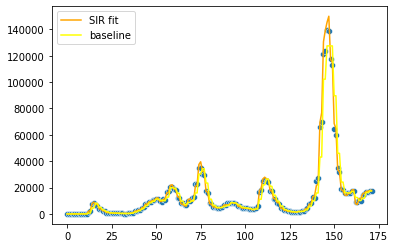

(0.29907022482835466,
 0.09634858952672307,
 890.6220878191587,
 4324394.1087366305,
 0.9926181824886482,
 0.06326566954348721)

In [116]:
# TODO BORRAR EVALUACIONES
def get_overall_results(plot=False):
    # overall evaluation 
    baseline_error = RMSLE(total_I_eval, total_baseline)
    #fit
    sir_RSMLE = RMSLE(total_I_eval, total_I_simulated)
    sir_MAE = mean_absolute_error(total_I_eval, total_I_simulated)
    sir_MSE = mean_squared_error(total_I_eval, total_I_simulated)
    sir_MAPE = mean_absolute_percentage_error(total_I_eval, total_I_simulated)

    if plot is True:
# TODO ARREGLAR ESTE PLOT 
        plt.plot(t[:len(total_I_simulated)], total_I_simulated, color='orange', label='SIR fit')
        plt.plot(t[:len(total_I_simulated)], total_baseline, color='yellow', label='baseline')
        sns.scatterplot(t[:len(total_I_simulated)], total_I_eval)
        plt.show()
    return baseline_error, sir_RSMLE, sir_MAE, sir_MSE, sir_MAPE

get_overall_results(plot=True)

# Walk forward validation: rolling windows

In [16]:
window_size = 7
step_size = 3


def sliding_window(data=[S, I, R], window_size=window_size, step_size=step_size):
    train = []
    test = []
    for compartiment in data:
        train.append(sliding_window_view(compartiment, window_shape=window_size))
        test.append(np.array([compartiment[i:i+step_size] for i in range(window_size, len(compartiment))]))
    return train, test



train, test = sliding_window()



def get_baseline(train=train, window_size=window_size, step_size=step_size):
    baselines = []
    for compartiment in train:
        baseline = []
        for window in compartiment:
            baseline.append(np.repeat(window[-1], step_size))           
        baselines.append(np.array(baseline))
    return baselines

In [17]:
# for each window, fit model and return next predictions
def fit_predict(S_window_train, I_window_train, R_window_train, return_only_predictions=False):   
    # define a SIR model
    model = comod.Model(
        ["S", "I", "R"],  # States
        ["beta", "gamma"],  # Coefficients
        [  # Rules in the form (origin, destination, coefficient)
            ("S", "I", "beta I / N"),  # N is a special state with the total population
            ("I", "R", "gamma"),
        ],
        # Special state names can be set with the following options:
        # Total population. Can be used in the coefficients, but not as origin/destination.
        sum_state="N", 
        # The nothingness (?) from which one is born and to which one dies.
        nihil_state="!",  # Can be used as origin/destination, but not in the cofficients.
    )
    
    # define time mesh
    t_window = np.arange(window_size) # time mesh for the window with step_size>window_size
    
    # best-fit model
    fit_pars = model.best_fit(
        np.asarray([S_window_train, I_window_train, R_window_train]), t_window, [0.1, 0.1]  # Existing data  # Time mesh  # Initial guess
    ).x

    fit_beta, fit_gamma = fit_pars

    S_simulated, I_simulated, R_simulated = model.solve(
        (S_window_train[0], I_window_train[0], R_window_train[0]),  # Initial state
        [fit_beta, fit_gamma],  # Coefficient values
        t=np.arange(window_size+step_size),  # Time mesh
        method="RK45",  # see scipy.integrate.solve_ivp
    )
    
    if return_only_predictions:
        return S_simulated[-step_size:], I_simulated[-step_size:], R_simulated[-step_size:]
    else:
        return S_simulated, I_simulated, R_simulated
        

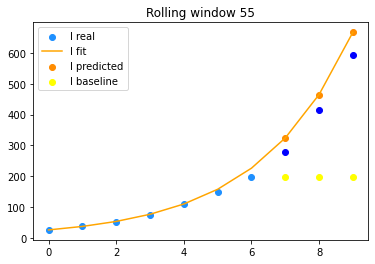

In [22]:
index = 55

S_window_train, I_window_train, R_window_train = train[0][index], train[1][index], train[2][index]
S_window_test, I_window_test, R_window_test = test[0][index], test[1][index], test[2][index]

S_fit, I_fit, R_fit = fit_predict(S_window_train, I_window_train, R_window_train)
baseline = get_baseline(train)

S_simulated, I_simulated, R_simulated = S_fit[:-step_size], I_fit[:-step_size], R_fit[:-step_size]
S_pred, I_pred, R_pred = S_fit[-step_size:], I_fit[-step_size:], R_fit[-step_size:]
S_baseline, I_baseline, R_baseline = baseline[0][index], baseline[1][index], baseline[2][index]


def plot_rolling_window():
    t=np.arange(window_size+step_size)
    plt.scatter(np.arange(len(I_window_train)), I_window_train, color='dodgerblue', label='I real')
    plt.plot(t, I_fit, color='orange', label='I fit')
    plt.scatter(t[-step_size:], I_pred, color='darkorange', label='I predicted')
    plt.scatter(t[-step_size:], I_window_test, color='blue')
    plt.scatter(t[-step_size:], I_baseline, color='yellow', label='I baseline')
    plt.legend()
    plt.title(f'Rolling window {index}')
    plt.show()

    
plot_rolling_window()

In [19]:
# get predictions for I windows 
I_pred = []

for S_window, I_window, R_window in zip(train[0], train[1], train[2]):
    window_pred = fit_predict(S_window, I_window, R_window, return_only_predictions=True)
    I_pred.append(window_pred[1])

In [21]:
metrics = [mean_absolute_error, mean_squared_error, mean_absolute_percentage_error]
metrics = {metric.__name__: metric for metric in metrics}

def evaluate_window(test_window, pred_window):
    window_metrics = {}

    for metric_name, metric in metrics.items():
        window_metrics['RMSLE'] = RMSLE(test_window, pred_window)
        try:
            window_metrics[metric_name] = metric(test_window, pred_window)
        except:
            window_metrics[metric_name] = np.nan
    return window_metrics

def get_global_evaluation(test=test, pred=I_pred):
    global_evaluation = []
    for test_window, pred_window in zip(test[1], I_pred):
        try:
            window_metrics = evaluate_window(test_window, pred_window)
        except:
            pass
        global_evaluation.append(window_metrics)
    return global_evaluation

In [25]:
results = []
baseline_results = []

for window_size in np.arange(5, 30):
    for step_size in np.arange(window_size+1, window_size+15):
        I_pred = []
        I_baseline = baseline[1]

        print(f'Window size: {window_size}, Step size: {step_size}')

        train, test = sliding_window(window_size=window_size, step_size=step_size)
        baseline = get_baseline(train)

        for S_window, I_window, R_window in zip(train[0], train[1], train[2]):
            window_pred = fit_predict(S_window, I_window, R_window, return_only_predictions=True)
            I_pred.append(window_pred[1])

        global_evaluation = get_global_evaluation(test, I_pred)
        global_evaluation = pd.DataFrame(global_evaluation).mean().to_dict()
        global_evaluation['window_size'] = window_size
        global_evaluation['step_size'] = step_size

        global_evaluation_baseline = get_global_evaluation(test, I_baseline)
        global_evaluation_baseline = pd.DataFrame(global_evaluation_baseline).mean().to_dict()
        global_evaluation_baseline['window_size'] = window_size
        global_evaluation_baseline['step_size'] = step_size       
        
        results.append(global_evaluation)
        baseline_results.append(global_evaluation_baseline)
                

Window size: 5, Step size: 6
Window size: 5, Step size: 7
Window size: 5, Step size: 8
Window size: 5, Step size: 9
Window size: 5, Step size: 10
Window size: 5, Step size: 11
Window size: 5, Step size: 12
Window size: 5, Step size: 13
Window size: 5, Step size: 14
Window size: 5, Step size: 15
Window size: 5, Step size: 16
Window size: 5, Step size: 17
Window size: 5, Step size: 18
Window size: 5, Step size: 19
Window size: 6, Step size: 7
Window size: 6, Step size: 8
Window size: 6, Step size: 9
Window size: 6, Step size: 10
Window size: 6, Step size: 11
Window size: 6, Step size: 12
Window size: 6, Step size: 13
Window size: 6, Step size: 14
Window size: 6, Step size: 15
Window size: 6, Step size: 16
Window size: 6, Step size: 17
Window size: 6, Step size: 18
Window size: 6, Step size: 19
Window size: 6, Step size: 20
Window size: 7, Step size: 8
Window size: 7, Step size: 9
Window size: 7, Step size: 10
Window size: 7, Step size: 11
Window size: 7, Step size: 12
Window size: 7, Ste

KeyboardInterrupt: 

In [119]:
r = pd.DataFrame(results)
r = r[r['window_size']<=30]
r

,RMSLE,mean_absolute_error,mean_squared_error,r2_score,mean_absolute_percentage_error,window_size,step_size
0,0.117191,1323.709315,1.589885e+07,-15.765893,0.101250,5,6
1,0.134995,1556.926023,2.333705e+07,-14.441286,0.117042,5,7
2,0.154015,1818.489171,3.371679e+07,-14.966022,0.134662,5,8
3,0.173932,2109.804887,4.803104e+07,-16.759886,0.154256,5,9
4,0.194800,2434.226056,6.754950e+07,-19.539264,0.176307,5,10
...,...,...,...,...,...,...,...
749,1.686448,74084.040053,2.203603e+11,-691.733441,4.180180,30,55
750,1.717651,76808.648035,2.330377e+11,-736.348416,4.476944,30,56
751,1.753848,79599.239696,2.458583e+11,-783.388437,4.796790,30,57
752,1.792096,82414.630440,2.588078e+11,-832.984738,5.136903,30,58


In [ ]:
# data path
base_dir = Path(os.getcwd()).parents[0]

# path to read final data
file_name_baseline = 'overall_eval_baseline.csv'
file_name_sir = 'overall_eval_sir.csv'

path_to_save_eval_data = base_dir / 'data' / 'final-data' 	

# overall_eval_baseline = pd.DataFrame(overall_eval_baseline).T
# overall_eval_sir = pd.DataFrame(overall_eval_sir).T

# overall_eval_baseline.to_csv(os.path.join(path_to_save_eval_data, file_name_baseline), index=True)
# overall_eval_sir.to_csv(os.path.join(path_to_save_eval_data, file_name_sir), index=True)

## Trial-error forecast days

In [22]:
%%time

window_sizes = []
step_sizes = []

overall_eval_sir = {}
overall_eval_baseline = {}

baseline_errors = []
sir_RMSLE=[]
sir_MAE=[]
sir_MSE=[]
sir_MAPE=[]

for window_size in np.arange(5, 60):
    for step_size in np.arange(window_size+1, window_size+30):
    # define a SIR model
        model = comod.Model(
            ["S", "I", "R"],  # States
            ["beta", "gamma"],  # Coefficients
            [  # Rules in the form (origin, destination, coefficient)
                ("S", "I", "beta I / N"),  # N is a special state with the total population
                ("I", "R", "gamma"),
            ],
            # Special state names can be set with the following options:
            # Total population. Can be used in the coefficients, but not as origin/destination.
            sum_state="N", 
            # The nothingness (?) from which one is born and to which one dies.
            nihil_state="!",  # Can be used as origin/destination, but not in the cofficients.
        )

        results = model.best_sliding_fit(
            np.asarray([S, I, R]),  # Existing data
            t,  # Time mesh
            [0.1, 0.1],  # Initial conditions
            window_size=window_size,  # Window size (number of time values in each window)
            step_size=step_size,  # Number of time steps between windows
            target=
            "y",  # The target to minimize can be "y" (values) or "dy" (their derivatives)
            time_criterion="first",  # Determines how a time is assigned to each window in the solution
        )

        try:
            print(f'Window size: {window_size}, Step size: {step_size}')

            total_S_simulated = []
            total_I_simulated = []
            total_R_simulated = []

            total_baseline = []
            total_I_eval = []

            window_evaluation_sir_metrics, window_evaluation_baseline_metrics = get_window_evaluation()
            mean_metrics_dict = pd.DataFrame(window_evaluation_sir_metrics).T.mean().to_dict()
            mean_baseline_metrics_dict = pd.DataFrame(window_evaluation_baseline_metrics).T.mean().to_dict()

            # add to overall_eval window_size, step_size and metrics dict of the window
            
            overall_eval_sir.update({(window_size, step_size): mean_metrics_dict})
            overall_eval_baseline.update({(window_size, step_size): mean_baseline_metrics_dict})

            
            # # baseline_error, sir_RSMLE, sir_MAE, sir_MSE, sir_MAPE = get_overall_results()
            # window_sizes.append(window_size)
            # step_sizes.append(step_size)
            # baseline_errors.append(baseline_error)
            # sir_RMSLE.append(sir_RMSLE)
            # sir_MAE.append(sir_MAE)
            # sir_MSE.append(sir_MSE)
            # sir_MAPE.append(sir_MAPE)
        except:
            print(f'NO Window size: {window_size}, Step size: {step_size}')
            continue

Window size: 5, Step size: 6
Window size: 5, Step size: 7
Window size: 5, Step size: 8
Window size: 5, Step size: 9
Window size: 5, Step size: 10
Window size: 5, Step size: 11
Window size: 5, Step size: 12
NO Window size: 5, Step size: 12
Window size: 5, Step size: 13
Window size: 5, Step size: 14
Window size: 5, Step size: 15
Window size: 5, Step size: 16
NO Window size: 5, Step size: 16
Window size: 5, Step size: 17
NO Window size: 5, Step size: 17
Window size: 5, Step size: 18
NO Window size: 5, Step size: 18
Window size: 5, Step size: 19
Window size: 5, Step size: 20
Window size: 5, Step size: 21
Window size: 5, Step size: 22
Window size: 5, Step size: 23
NO Window size: 5, Step size: 23
Window size: 5, Step size: 24
NO Window size: 5, Step size: 24
Window size: 5, Step size: 25
NO Window size: 5, Step size: 25
Window size: 5, Step size: 26
Window size: 5, Step size: 27
NO Window size: 5, Step size: 27
Window size: 5, Step size: 28
NO Window size: 5, Step size: 28
Window size: 5, S

In [10]:
# data path
base_dir = Path(os.getcwd()).parents[0]

# path to read final data
file_name_baseline = 'overall_eval_baseline.csv'
file_name_sir = 'overall_eval_sir.csv'

path_to_save_eval_data = base_dir / 'data' / 'final-data' 	

# overall_eval_baseline = pd.DataFrame(overall_eval_baseline).T
# overall_eval_sir = pd.DataFrame(overall_eval_sir).T

# overall_eval_baseline.to_csv(os.path.join(path_to_save_eval_data, file_name_baseline), index=True)
# overall_eval_sir.to_csv(os.path.join(path_to_save_eval_data, file_name_sir), index=True)

In [11]:
overall_eval_baseline = pd.read_csv(os.path.join(path_to_save_eval_data, file_name_baseline))
overall_eval_baseline

,Unnamed: 0,Unnamed: 1,RMSLE,mean_absolute_error,mean_squared_error,r2_score,mean_absolute_percentage_error
0,5,6,0.122470,1526.759441,1.044194e+07,NaN,0.114477
1,5,7,0.129224,1584.243443,1.233329e+07,-6221.114213,0.116720
2,5,8,0.172610,2162.764486,2.204453e+07,-46.391400,0.153420
3,5,9,0.204233,2471.451053,2.896365e+07,-28.180661,0.177058
4,5,10,0.220035,2725.001860,3.645641e+07,-30.345580,0.189076
...,...,...,...,...,...,...,...
1499,59,84,1.461865,14020.199458,8.182358e+08,-85.848415,1.321052
1500,59,85,1.315877,8730.409518,3.227465e+08,-69.246526,1.162622
1501,59,86,1.311547,7029.235530,1.328798e+08,-77.985386,1.207219
1502,59,87,1.454562,9261.691949,2.682299e+08,-102.266652,1.422636
